# Imports e Globais

https://www.hfbrasil.org.br/br/estatistica/batata.aspx

https://cepea.esalq.usp.br/br/consultas-ao-banco-de-dados-do-site.aspx


In [88]:
import pandas as pd
import polars as pl
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import batelada as bt
import scipy as sp
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from itertools import product

figsize = (20, 10)

In [104]:
import warnings
warnings.filterwarnings("ignore")

# Funções

In [2]:
def testes_normalidade(resid):
    print(f"D'Agostino's K-squared test: {sp.stats.normaltest(resid)}\n")
    print(f"FKolmogorov-Smirnov test: {sp.stats.kstest(resid, 'norm')}\n")
    print(f"Lilliefors test: {sm.stats.diagnostic.lilliefors(resid, dist='norm', pvalmethod='table')}\n")
    print(f"Shapiro-Wilk test: {sp.stats.shapiro(resid)}\n")


In [3]:
def plot_resid(t, resid, title):
    # Plota a figura
    plt.figure(figsize=figsize)
    sns.lineplot(x=t, y=resid, color="red", linestyle="-", label="Um passo a frente")
    plt.title(title)
    plt.legend(labels=["Um passo a frente"])
    plt.xlabel("Amostra")
    plt.ylabel("Erro")
    plt.grid()
    plt.show()
    plt.close()


In [4]:
def ked_resid(resid, title):
    # Plota a figura
    plt.figure(figsize=figsize)
    sns.kdeplot(x=resid, color="red", linestyle="-", label="Um passo a frente")
    plt.title(
        f"""{title}
    Média: {(resid).mean():.3}
    Desvio padrão: {(resid).std():.3}"""
    )
    plt.legend(labels=["Um passo a frente"])
    plt.xlabel("Erro")
    plt.ylabel("KDE")
    plt.grid()
    plt.show()
    plt.close()


In [5]:
def plot_serie(t, y, yest, title):
    # Plota a figura
    plt.figure(figsize=figsize)
    sns.scatterplot(x=t, y=y, color="green", markers=".", label="Pontos medidos")
    sns.lineplot(x=t, y=yest, color="red", linestyle="-", label="Um passo a frente")
    plt.title(title)
    plt.legend(labels=["Real", "Um passo a frente"])
    plt.xlabel("Amostra")
    plt.ylabel("Saída")
    plt.grid()
    plt.show()
    plt.close()


In [93]:
def plots_metricas_arma(resid, t, y, yest, ra, ma, mse):
    print(f"Modelo ra:{ra} ma:{ma}\n")

    testes_normalidade(resid)
    print(f"Mean Square Error: {mse:.3}\n")

    title = f"Desempenho"
    plot_serie(t, y, yest, title)

    title = f"Residuos"
    plot_resid(t, resid, title)

    title = f"Distribuição dos residuos"
    ked_resid(resid, title)


In [ ]:
def train_arma(y, train, ra, ma):
    arma = ARIMA(endog=y[:train], order=(ra, 0, ma)).fit()
    mse = arma.mse
    params = dict(zip(arma.param_names,arma.params))
    yest = arma.predict(0, len(y)-1)
    resid = y-yest
    return resid, mse, params, yest

# Batata


## Pré-processamento dos dados


In [34]:
df_batata = pd.read_excel("20221001214857-precos-medios-batata.xlsx")
df_batata = pl.DataFrame(df_batata)
date_batata = df_batata.select(
    pl.date(year=pl.col("Ano"), month=pl.col("Mês"), day=pl.col("Dia")).alias("Data")
)
df_batata = df_batata.with_column(date_batata.to_series())


In [35]:
df_agata = df_batata.filter(
    (pl.col("Produto") == "Padrão agata primeira - beneficiador")
    & (pl.col("Unidade") == "saco 50 kg")
    & (pl.col("Data").is_between(pl.datetime(2008, 1, 1), pl.datetime(2020, 12, 31)))
).select(["Data", "Preço", "Ano", "Mês"])


df_agata = (
    df_agata.groupby(["Ano", "Mês"])
    .agg(
        [
            pl.col("Preço").mean().alias("Preço médio"),
            pl.col("Preço").std().alias("Preço desvio"),
            pl.col("Preço").min().alias("Preço menor"),
            pl.col("Preço").max().alias("Preço maior"),
        ]
    )
    .select(
        [
            pl.all(),
            pl.date(year=pl.col("Ano"), month=pl.col("Mês"), day=1).alias("Data"),
        ]
    )
    .sort("Data")
)

df_agata = df_agata.upsample("Data", "1mo").interpolate().fill_null("forward")


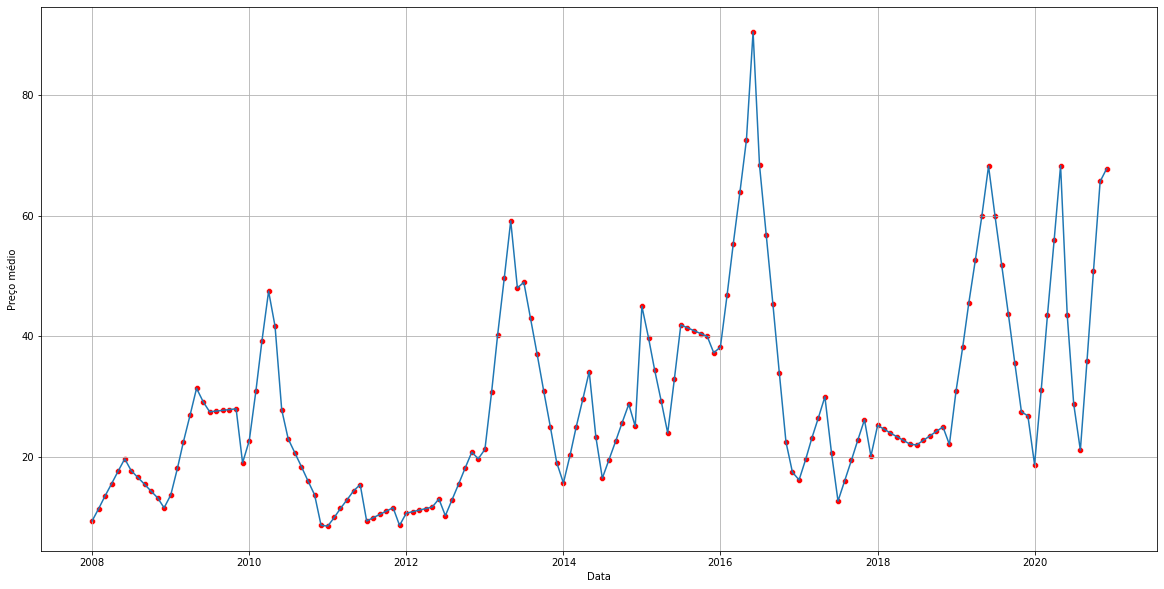

In [36]:
plt.figure(figsize=figsize)
sns.lineplot(data=df_agata.to_pandas(), x="Data", y="Preço médio")
sns.scatterplot(data=df_agata.to_pandas(), x="Data", y="Preço médio", color="red")
plt.grid()
plt.show()
plt.close()


## Carregar dados

In [105]:
data = df_agata.select(["Mês", "Preço médio"]).to_numpy()

u = np.random.normal(
    size=len(data[:, 0])
)  # Entrada aleatória, o algoritmo precisa dela, mas não existem entradas relevantes
y = data[:, 1]  # Salva os dados de saídas

u = u / u.std()
y = y / y.std()

print(f"Número de pontos: {u.size}")
train, test, t = 110, 46, np.arange(len(y))

Número de pontos: 156


## Modelo AR


In [10]:
na, nb = 3, 0
delay = 0
yest, yest_n, theta = bt.gerar_dados(na, nb, u, y, delay, train=0.7)
deep = max(na, nb)
npts = u.size

# Mean Squared Error (MSE) – objetivo é um menor MSE
mse = np.sum((y - yest) ** 2) / (npts - deep)

t = np.arange(y.size)


### Plots e Metricas


In [11]:
resid = y - yest
testes_normalidade(resid)
print(f"Mean Square Error: {mse:.3}")


D'Agostino's K-squared test: NormaltestResult(statistic=35.29810071886683, pvalue=2.1632903753055884e-08)

FKolmogorov-Smirnov test: KstestResult(statistic=0.28171996365220553, pvalue=1.910986187902116e-11)

Lilliefors test: (0.09923349377681057, 0.0018067206198010756)

Shapiro-Wilk test: ShapiroResult(statistic=0.9226043224334717, pvalue=1.9969907327777037e-07)

Mean Square Error: 0.162


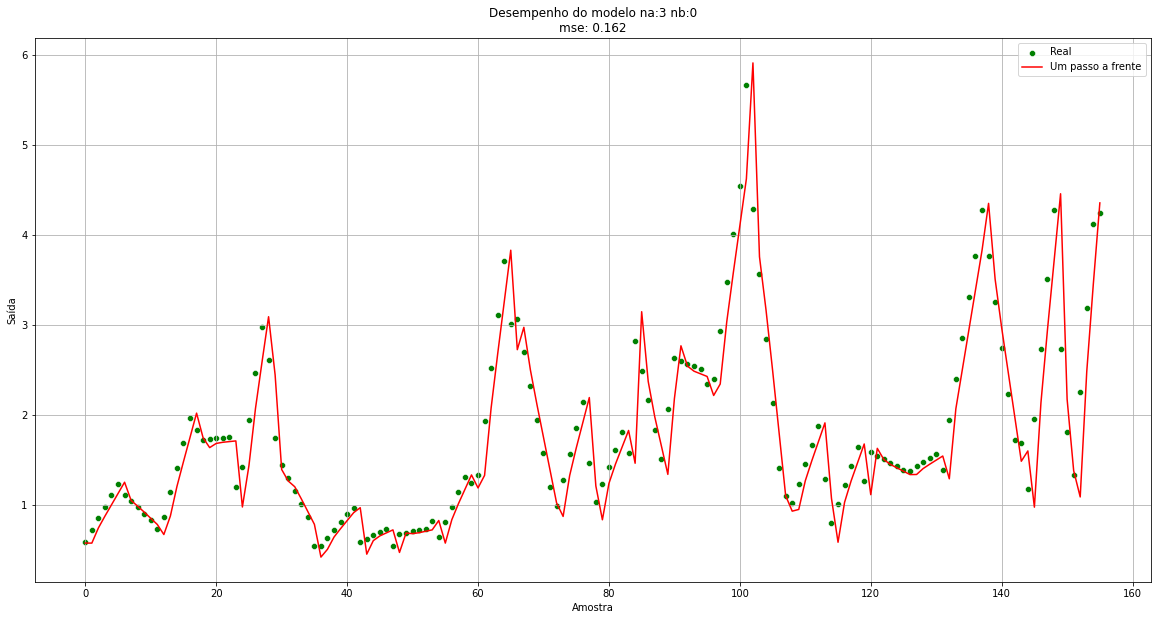

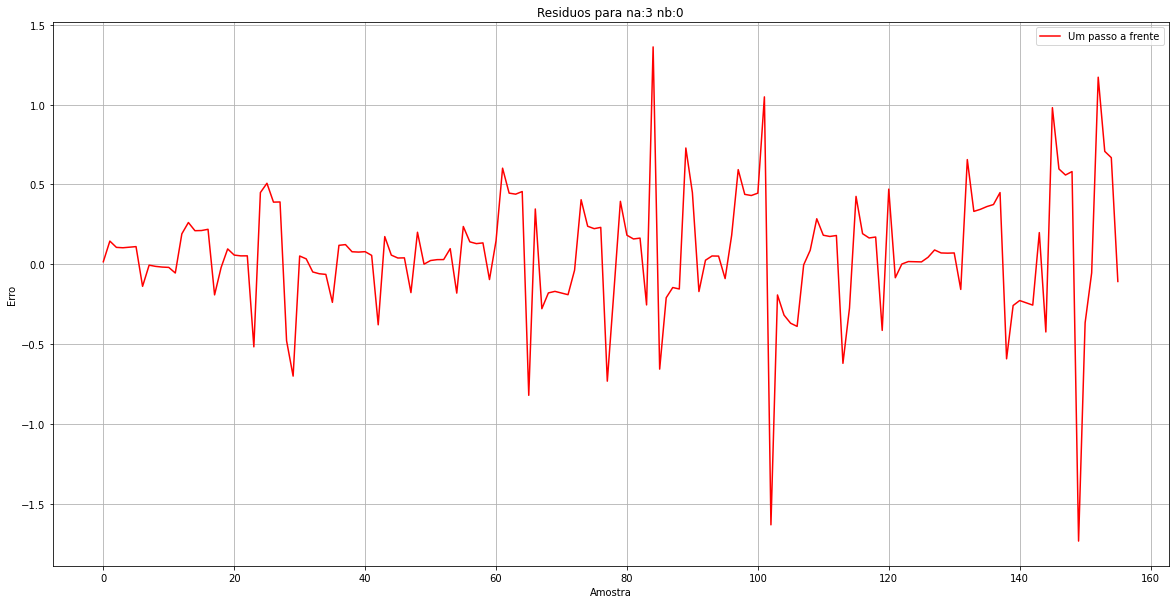

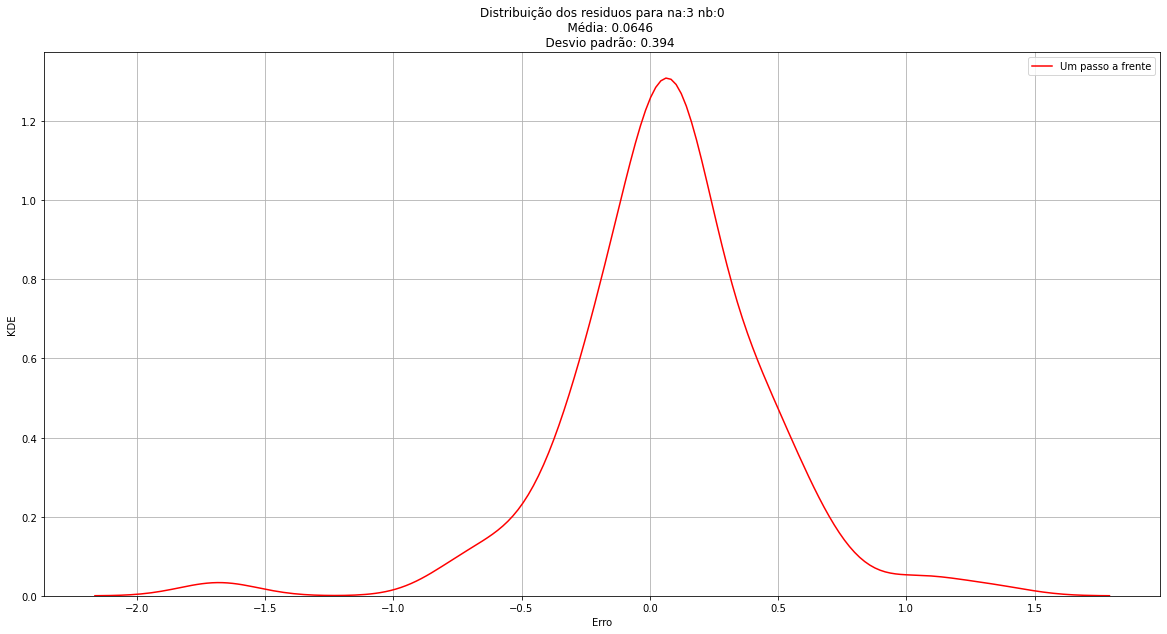

In [12]:
title = f"Desempenho do modelo na:{na} nb:{nb}\nmse: {mse:.3}"
plot_serie(t, y, yest, title)

title = f"Residuos para na:{na} nb:{nb}"
plot_resid(t, resid, title)

title = f"Distribuição dos residuos para na:{na} nb:{nb}"
ked_resid(resid, title)


## Modelo ARMA


Modelo ra:9 ma:7

D'Agostino's K-squared test: NormaltestResult(statistic=79.77893255295527, pvalue=4.744876467209455e-18)

FKolmogorov-Smirnov test: KstestResult(statistic=0.3121258779350685, pvalue=5.313570718314864e-14)

Lilliefors test: (0.22746928888290463, 0.0009999999999998899)

Shapiro-Wilk test: ShapiroResult(statistic=0.7657418251037598, pvalue=1.6606872059693294e-14)

Mean Square Error: 0.115



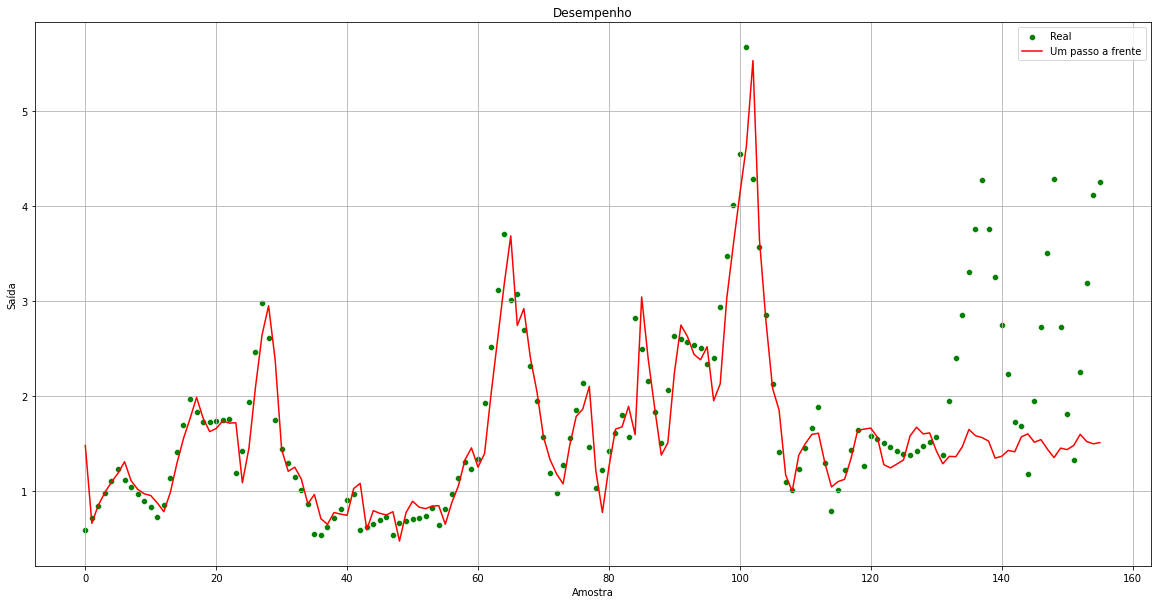

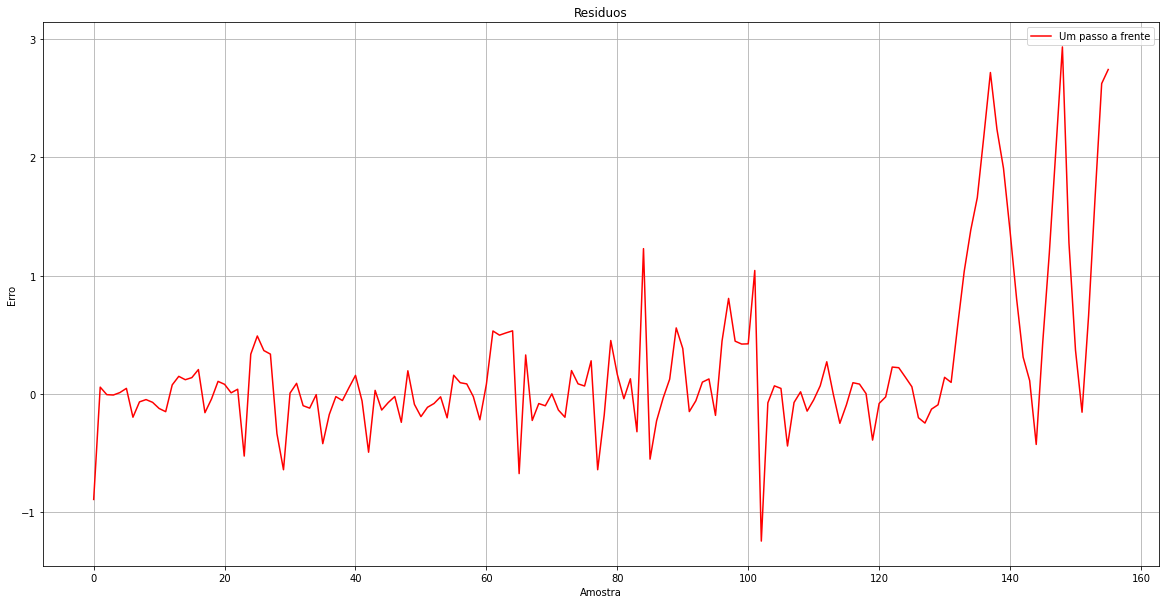

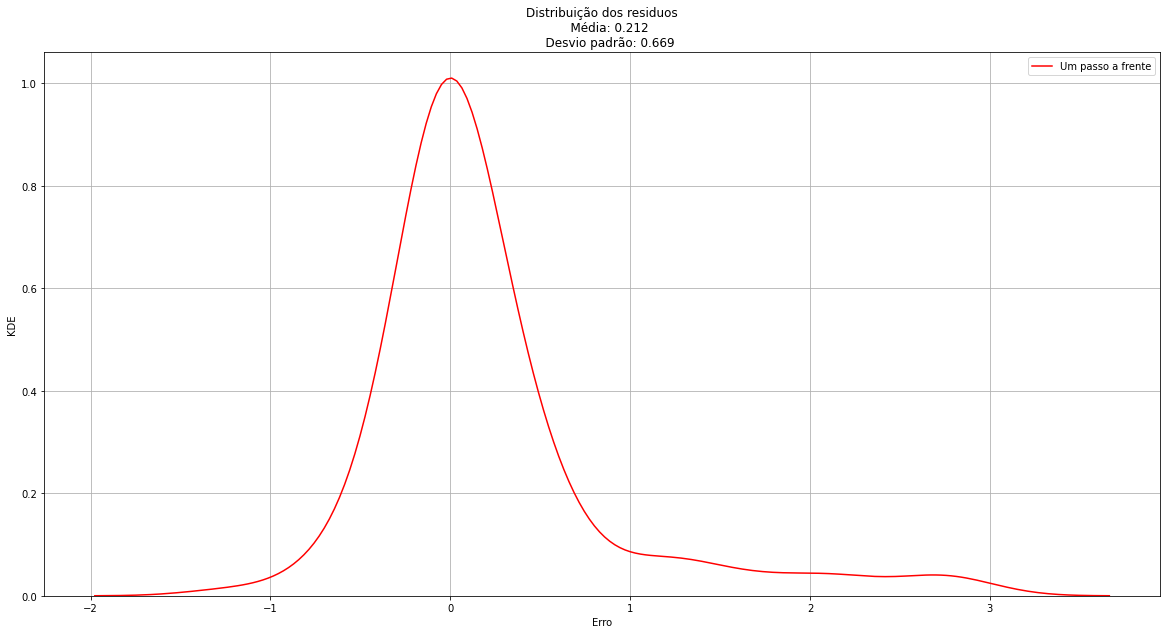

In [107]:
mse_low = np.Inf
best = (0, 0)

for ra, ma in product(range(10), range(10)):
    _, mse, _, _ = train_arma(y, train, ra, ma)
    if mse_low > mse:
        best = (ra,ma)
        mse_low = mse

ra, ma = best
resid, mse, params, yest = train_arma(y, train, ra, ma)
plots_metricas_arma(resid, t, y, yest, ra, ma, mse)

# Leite


## Pré-processamento


In [16]:
df_leite = pd.read_excel("cepea-consulta-20221001213951-leite.xls")
df_leite = pl.DataFrame(df_leite)
columns = df_leite.columns[1:]
columns = [
    df_leite[c].str.replace(",", ".").str.replace("-", "NaN").apply(float).alias(c)
    for c in columns
]
df_leite = df_leite.with_columns(columns)
df_leite = df_leite.with_column(
    ("01/" + pl.col("Data")).str.strptime(pl.Date, fmt="%d/%m/%Y").alias("Data")
)
df_leite = df_leite.select(
    [pl.col("Data"), pl.col("Preço líquido médio").alias("Preço")]
)


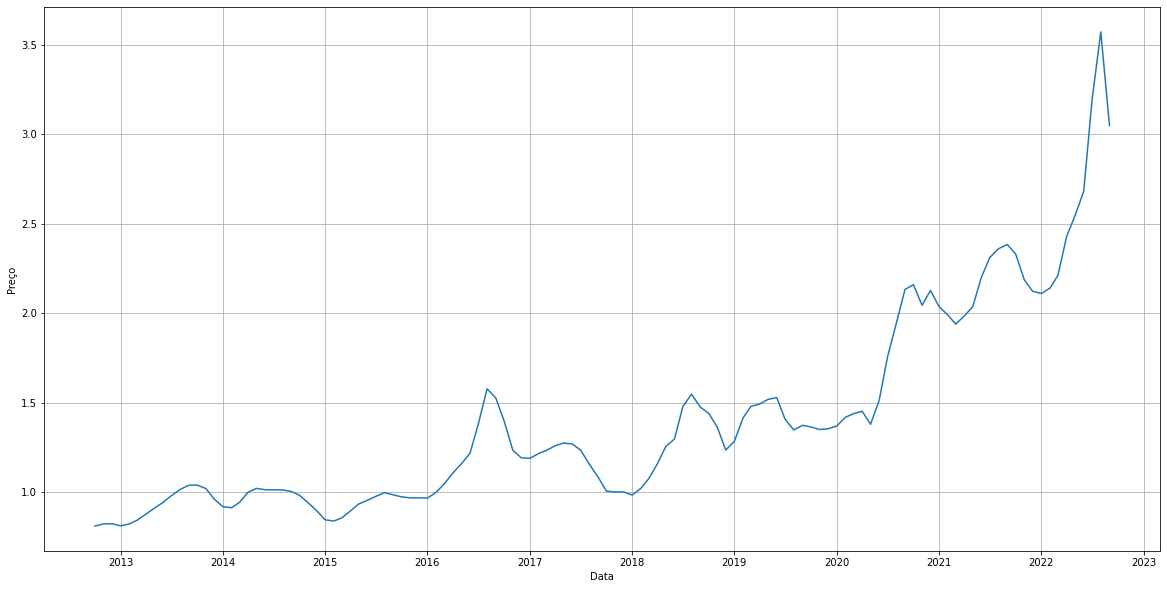

In [17]:
plt.figure(figsize=figsize)
sns.lineplot(data=df_leite.to_pandas(), x="Data", y="Preço")
plt.grid()
plt.show()
plt.close()


In [18]:
data = df_leite.select([pl.col("Data").dt.month(), "Preço"]).to_numpy()

print("Método dos mínimos quadrados em batelada")
u = np.random.normal(
    size=len(data[:, 0])
)  # Entrada aleatória, o algoritmo de LS precisa dela, mas não existem entradas relevantes
y = data[:, 1]  # Salva os dados de saídas

u = u / u.std()
y = y / y.std()

print(f"Número de pontos: {u.size}")


Método dos mínimos quadrados em batelada
Número de pontos: 120


## AR


In [19]:
na, nb = 3, 0
delay = 0
yest, yest_n, theta = bt.gerar_dados(na, nb, u, y, delay, train=0.7)
deep = max(na, nb)
npts = u.size

# Mean Squared Error (MSE) – objetivo é um menor MSE
mse = np.sum((y - yest) ** 2) / (npts - deep)

t = np.arange(y.size)


### Plots e Metricas


In [20]:
resid = y - yest
testes_normalidade(resid)
print(f"Mean Square Error: {mse:.3}")


D'Agostino's K-squared test: NormaltestResult(statistic=85.62831105293031, pvalue=2.5471147307328913e-19)

FKolmogorov-Smirnov test: KstestResult(statistic=0.3982507447339736, pvalue=1.10698485679656e-17)

Lilliefors test: (0.19856571770420084, 0.0009999999999998899)

Shapiro-Wilk test: ShapiroResult(statistic=0.7028815746307373, pvalue=2.9050421329569406e-14)

Mean Square Error: 0.0289


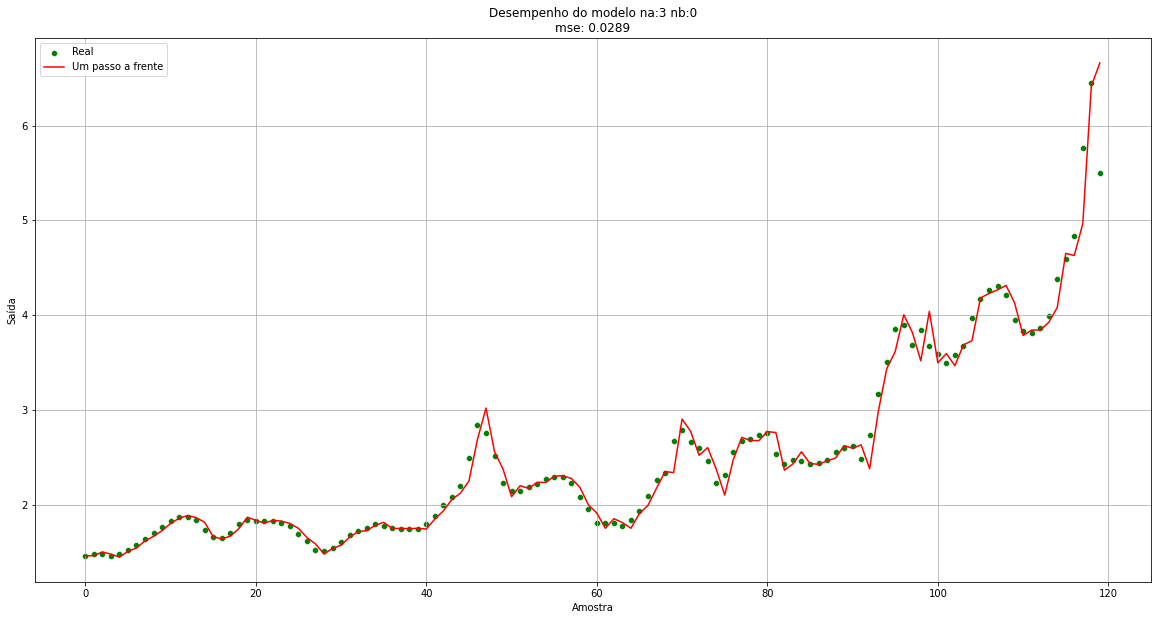

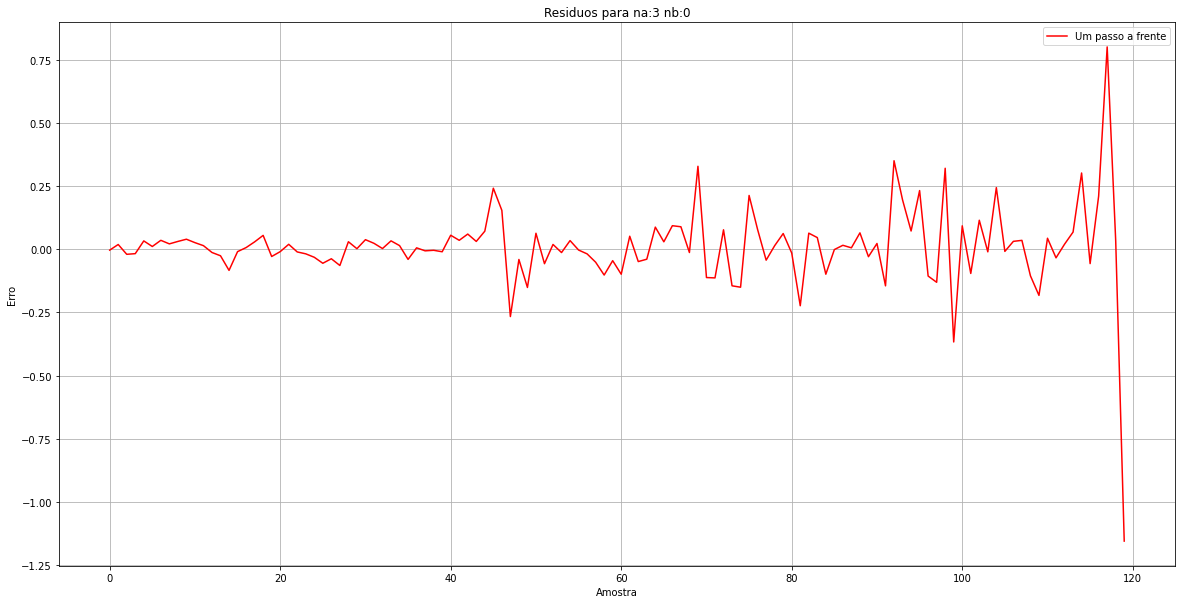

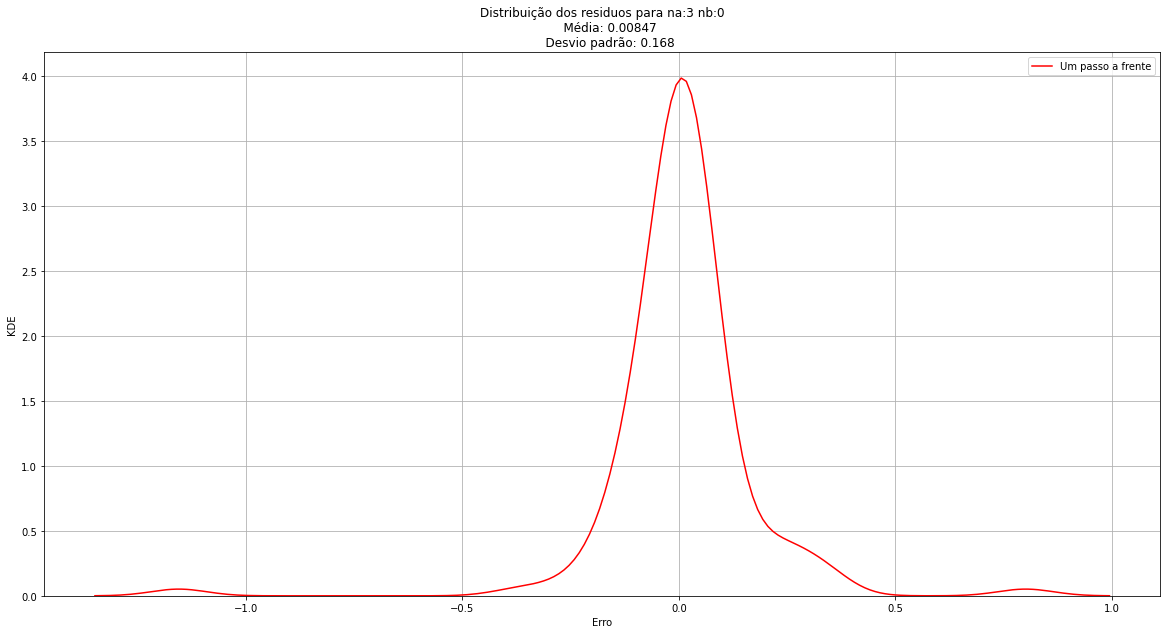

In [21]:
title = f"Desempenho do modelo na:{na} nb:{nb}\nmse: {mse:.3}"
plot_serie(t, y, yest, title)

title = f"Residuos para na:{na} nb:{nb}"
plot_resid(t, resid, title)

title = f"Distribuição dos residuos para na:{na} nb:{nb}"
ked_resid(resid, title)


## Modelo ARMA


In [30]:
mse_low = np.Inf
best = (0, 0)

for ra, ma in product(range(10), range(10)):
    _, mse, _, _ = train_arma(y, train, ra, ma)
    if mse_low > mse:
        best = (ra,ma)
        mse_low = mse

ra, ma = best
resid, mse, params, yest = train_arma(y, train, ra, ma)
plots_metricas_arma(resid, t, y, yest, ra, ma, mse)